### Estuardo J. Díaz García
-----
# Laboratorio 3. Comentarios. Parte 1

## K-NN de opiniones

In [35]:
import itertools #librería que permite iteraciones
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sb
from sklearn.metrics import classification_report

In [36]:
df_comentarios = pd.read_csv("comentarios.csv",sep=';')

df_comentarios.head(10)

,Review Title,Review Text,wordcount,titleSentiment,textSentiment,Star Rating,sentimentValue
0,Sin conexión,Hola desde hace algo más de un mes me pone sin...,23,negative,negative,1,-0.486389
1,faltan cosas,Han mejorado la apariencia pero no,20,negative,negative,1,-0.586187
2,Es muy buena lo recomiendo,Andres e puto amoooo,4,NaN,negative,1,-0.602240
3,Version antigua,Me gustana mas la version anterior esta es mas...,17,NaN,negative,1,-0.616271
4,Esta bien,Sin ser la biblia.... Esta bien,6,negative,negative,1,-0.651784
5,Buena,Nada del otro mundo pero han mejorado mucho,8,positive,negative,1,-0.720443
6,De gran ayuda,"Lo malo q necesita de …,pero la app es muy buena",23,positive,negative,1,-0.726825
7,Muy buena,"Estaba más acostumbrado al otro diseño, pero e...",16,positive,negative,1,-0.736769
8,Ta to guapa.,Va de escándalo,21,positive,negative,1,-0.765284
9,Se han corregido,Han corregido muchos fallos pero el diseño es ...,13,negative,negative,1,-0.797961


### Exploramos las características del dataset

In [37]:
df_comentarios.describe()

,wordcount,Star Rating,sentimentValue
count,257.000000,257.000000,257.000000
mean,11.501946,3.420233,0.383849
std,13.159812,1.409531,0.897987
min,1.000000,1.000000,-2.276469
25%,3.000000,3.000000,-0.108144
50%,7.000000,3.000000,0.264091
75%,16.000000,5.000000,0.808384
max,103.000000,5.000000,3.264579


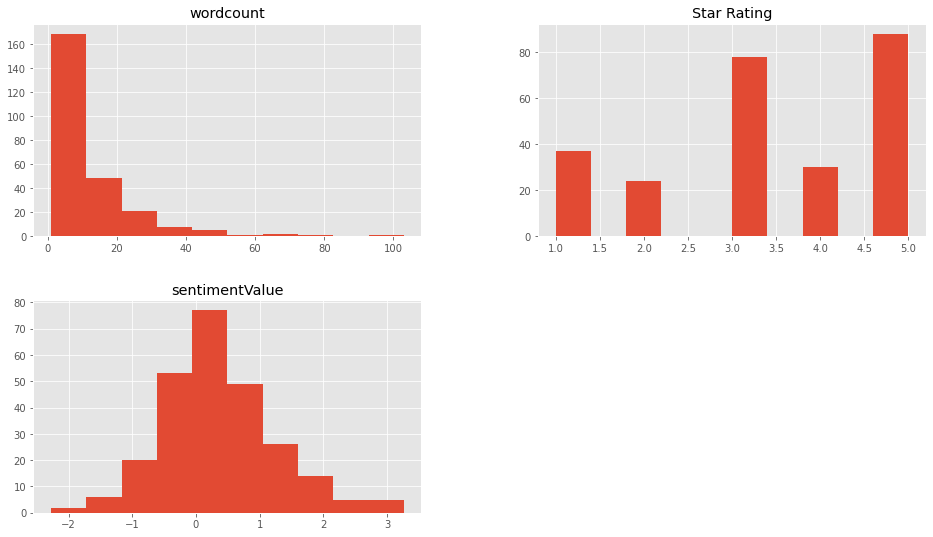

In [38]:
df_comentarios.hist()
plt.show()

In [39]:
print(df_comentarios.groupby('Star Rating').size()) #La mayoría de comentarios son de 5 y de 3 estrellas, respectivamente

Star Rating
1    37
2    24
3    78
4    30
5    88
dtype: int64


### Transformamos la data

In [40]:
#Como vamos a usar las columnas de "wordcount", "titleSentiment", "textSentiment" y "sentimentValue"
#Vamos a eliminar las filas que continen NaN dado que esto distorsiona nuestro modelo
df_comentarios = df_comentarios.dropna()

In [41]:
df_comentarios.describe() #La nueva información queda así

,wordcount,Star Rating,sentimentValue
count,231.000000,231.000000,231.000000
mean,11.709957,3.398268,0.370385
std,12.976495,1.416302,0.909308
min,1.000000,1.000000,-2.276469
25%,3.000000,3.000000,-0.107949
50%,7.000000,3.000000,0.246869
75%,16.000000,5.000000,0.791747
max,103.000000,5.000000,3.264579


In [42]:
print(df_comentarios.groupby('Star Rating').size())
#La mayoría de comentarios sigue estando en las 5 y de 3 estrellas, respectivamente

Star Rating
1    34
2    23
3    69
4    27
5    78
dtype: int64


In [43]:
#Vamos a transformar algunas columnas no numéricas a variables dummy para poderlas usar en nuestro modelo KNN

#En la columna "titleSentiment" negative = 0 y positive = 1:
df_comentarios.loc[df_comentarios["titleSentiment"] == "negative", "titleSentiment"] = 0
df_comentarios.loc[df_comentarios["titleSentiment"] == "positive", "titleSentiment"] = 1

#En la columna "textSentiment" negative = 0 y positive = 1:
df_comentarios.loc[df_comentarios["textSentiment"] == "negative", "textSentiment"] = 0
df_comentarios.loc[df_comentarios["textSentiment"] == "positive", "textSentiment"] = 1

df_comentarios[["titleSentiment"]] = df_comentarios[["titleSentiment"]].astype(float)
df_comentarios[["textSentiment"]] = df_comentarios[["textSentiment"]].astype(float)

In [44]:
df_comentarios.corr()

,wordcount,titleSentiment,textSentiment,Star Rating,sentimentValue
wordcount,1.000000,-0.315648,-0.271472,-0.413835,-0.351401
titleSentiment,-0.315648,1.000000,0.447293,0.357556,0.289145
textSentiment,-0.271472,0.447293,1.000000,0.696731,0.628439
Star Rating,-0.413835,0.357556,0.696731,1.000000,0.785951
sentimentValue,-0.351401,0.289145,0.628439,0.785951,1.000000


In [45]:
df_comentarios.head(10)

,Review Title,Review Text,wordcount,titleSentiment,textSentiment,Star Rating,sentimentValue
0,Sin conexión,Hola desde hace algo más de un mes me pone sin...,23,0.0,0.0,1,-0.486389
1,faltan cosas,Han mejorado la apariencia pero no,20,0.0,0.0,1,-0.586187
4,Esta bien,Sin ser la biblia.... Esta bien,6,0.0,0.0,1,-0.651784
5,Buena,Nada del otro mundo pero han mejorado mucho,8,1.0,0.0,1,-0.720443
6,De gran ayuda,"Lo malo q necesita de …,pero la app es muy buena",23,1.0,0.0,1,-0.726825
7,Muy buena,"Estaba más acostumbrado al otro diseño, pero e...",16,1.0,0.0,1,-0.736769
8,Ta to guapa.,Va de escándalo,21,1.0,0.0,1,-0.765284
9,Se han corregido,Han corregido muchos fallos pero el diseño es ...,13,0.0,0.0,1,-0.797961
10,Parece que va mejor.,No se cuelga tanto,4,1.0,0.0,1,-0.833488
11,Dice q hay una nueva versión?,Xq no me sale la opción de actualizarla entonces?,9,0.0,0.0,1,-0.838467


In [46]:
df_comentarios.columns

Index(['Review Title', 'Review Text', 'wordcount', 'titleSentiment',
       'textSentiment', 'Star Rating', 'sentimentValue'],
      dtype='object')

In [47]:
x = df_comentarios[['wordcount','textSentiment','sentimentValue']].values #Se escogieron variables X de acuerdo a correlación
y = df_comentarios['Star Rating'].values

x = preprocessing.StandardScaler().fit(x).transform(x.astype(float))



In [48]:
#Generamos el set de entrenamiento y el de testeo
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

print ('Set de Entrenamiento:', x_train.shape,  y_train.shape)
print ('Set de Prueba:', x_test.shape,  y_test.shape)

Set de Entrenamiento: (184, 3) (184,)
Set de Prueba: (47, 3) (47,)


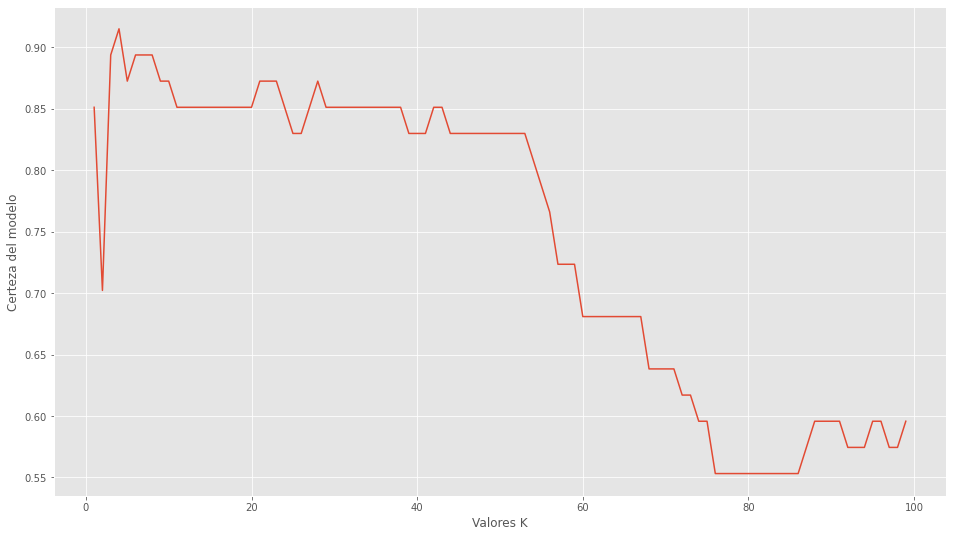

[0.851063829787234, 0.7021276595744681, 0.8936170212765957, 0.9148936170212766, 0.8723404255319149, 0.8936170212765957, 0.8936170212765957, 0.8936170212765957, 0.8723404255319149, 0.8723404255319149, 0.851063829787234, 0.851063829787234, 0.851063829787234, 0.851063829787234, 0.851063829787234, 0.851063829787234, 0.851063829787234, 0.851063829787234, 0.851063829787234, 0.851063829787234, 0.8723404255319149, 0.8723404255319149, 0.8723404255319149, 0.851063829787234, 0.8297872340425532, 0.8297872340425532, 0.851063829787234, 0.8723404255319149, 0.851063829787234, 0.851063829787234, 0.851063829787234, 0.851063829787234, 0.851063829787234, 0.851063829787234, 0.851063829787234, 0.851063829787234, 0.851063829787234, 0.851063829787234, 0.8297872340425532, 0.8297872340425532, 0.8297872340425532, 0.851063829787234, 0.851063829787234, 0.8297872340425532, 0.8297872340425532, 0.8297872340425532, 0.8297872340425532, 0.8297872340425532, 0.8297872340425532, 0.8297872340425532, 0.8297872340425532, 0.82

In [49]:
k_range = range(1,100) #Vemos que K es el más certero
certeza = {}
certeza_list = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k).fit(x_train,y_train)
    y_hat = knn.predict(x_test)
    certeza[k] = metrics.accuracy_score(y_test,y_hat)
    certeza_list.append(metrics.accuracy_score(y_test,y_hat))
    
plt.plot(k_range,certeza_list)
plt.xlabel("Valores K")
plt.ylabel("Certeza del modelo")
plt.show()

print(certeza_list) #vemos que el k=3 tiene una adecuada certeza del 89.4%

In [50]:
k = 3 #el parámetro K definido por el usuario

neighbor = KNeighborsClassifier(n_neighbors = k).fit(x_train,y_train)

yhat = neighbor.predict(x_test) #predecimos el test de prueba 


print("Certeza en el set de prueba: ", metrics.accuracy_score(y_train, neighbor.predict(x_train)))
print("Certeza en el set de testeo: ", metrics.accuracy_score(y_test, yhat))

Certeza en el set de prueba:  0.9293478260869565
Certeza en el set de testeo:  0.8936170212765957


## Modelo final

In [51]:
k=3 #Usamos el K más certero
rating_pred = KNeighborsClassifier(n_neighbors = k).fit(x_train,y_train) #entrenamos el modelo
y_hat = rating_pred.predict(x_test) #lo corremos con el test de prueba nuevamente

In [55]:
print(confusion_matrix(y_test, y_hat))
#Vemos que con k=3 el modelo es bastante certero, solamente 5 observaciones fueron incorrectas de 47

[[ 7  0  0  0  0]
 [ 0  4  0  0  0]
 [ 0  0 14  0  2]
 [ 0  0  1  3  1]
 [ 0  0  1  0 14]]
